In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


# Load and Clean data

In [54]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [55]:
dataset = raw_dataset.copy()
dataset.describe()

MPG   Cylinders  Displacement  Horsepower       Weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       Acceleration  Model Year      Origin  
count    398.000000  398.000000  398.000000  
mean      15.568090   76.010050    1.572864  
std        2.757689    3.697627    0.802055  
min        8.000000   70.000000    1.000000  
25%       13.825000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.175000   79.000000    2.000000  
max       24.800000   82.000000    3.000000

In [56]:
dataset.isna().sum()
dataset = dataset.dropna()

In [57]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
393          82       0      0    1  
394          82       1      0    0  
395          82       0      0    1  
396          82       0      0    1  
397          82       0      0    1

# Split Training and Test Data

In [58]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

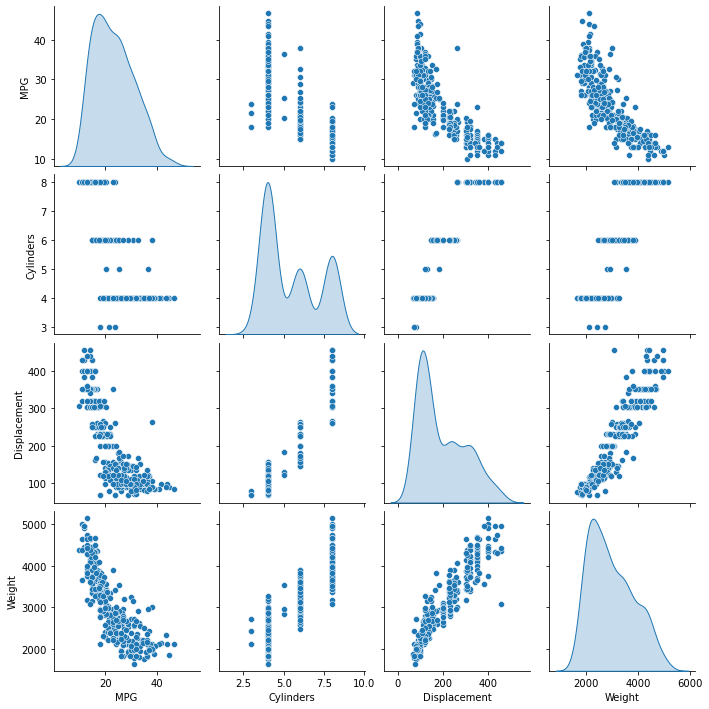

In [59]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [60]:
train_dataset.describe().transpose()

count         mean         std     min      25%     50%  \
MPG           314.0    23.310510    7.728652    10.0    17.00    22.0   
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   

                  75%     max  
MPG             28.95    46.6  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
Europe           0.00     1.0  
Japan            0.00     1.0  
USA              1.00     1.0

# Separate features and labels

In [61]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalise the data

In [62]:
train_dataset.describe().transpose()[['mean', 'std']]

mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
Europe           0.178344    0.383413
Japan            0.197452    0.398712
USA              0.624204    0.485101

In [63]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
 7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]


In [64]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression

In [65]:
# Build the model

In [66]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [67]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [68]:
horsepower_model.predict(horsepower[:10])

array([[-0.99549806],
       [-0.5622299 ],
       [ 1.8374095 ],
       [-1.3954378 ],
       [-1.2621245 ],
       [-0.49557316],
       [-1.495423  ],
       [-1.2621245 ],
       [-0.32893157],
       [-0.5622299 ]], dtype=float32)

In [69]:

class CustomAccuracy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_pred-y_true))
        rmse = tf.math.sqrt(mse)
        return tf.math.abs(rmse / tf.reduce_mean(tf.square(y_true)) - 1)

In [70]:
# COmpile the model
#horsepower_model.compile(
#    optimizer=tf.optimizers.Adam(learning_rate=0.1),
#    loss='mean_absolute_error')

horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=CustomAccuracy())

In [71]:
# train the model

history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=200,
    # suppress logging
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/200
8/8 [==============================] - 1s 41ms/step - loss: 0.9579 - val_loss: 0.9578
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9570 - val_loss: 0.9562
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9550 - val_loss: 0.9545
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.9534 - val_loss: 0.9529
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9514 - val_loss: 0.9512
Epoch 6/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9493 - val_loss: 0.9495
Epoch 7/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9471 - val_loss: 0.9478
Epoch 8/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9451 - val_loss: 0.9460
Epoch 9/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9444 - val_loss: 0.9443
Epoch 10/200
8/8 [==============================] - 0s 13ms/step - loss: 0.9434 - val_loss: 0.9425
Epoch 11/200
8/8 [=

Epoch 84/200
8/8 [==============================] - 0s 13ms/step - loss: 0.8012 - val_loss: 0.8011
Epoch 85/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7993 - val_loss: 0.7992
Epoch 86/200
8/8 [==============================] - 0s 13ms/step - loss: 0.8050 - val_loss: 0.7973
Epoch 87/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7936 - val_loss: 0.7954
Epoch 88/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7914 - val_loss: 0.7935
Epoch 89/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7983 - val_loss: 0.7916
Epoch 90/200
8/8 [==============================] - 0s 26ms/step - loss: 0.7928 - val_loss: 0.7897
Epoch 91/200
8/8 [==============================] - 0s 26ms/step - loss: 0.7894 - val_loss: 0.7878
Epoch 92/200
8/8 [==============================] - 0s 29ms/step - loss: 0.7862 - val_loss: 0.7859
Epoch 93/200
8/8 [==============================] - 0s 14ms/step - loss: 0.7758 - val_loss: 0.7840
Epoch 94/2

8/8 [==============================] - 0s 13ms/step - loss: 0.6489 - val_loss: 0.6472
Epoch 167/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6302 - val_loss: 0.6454
Epoch 168/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6432 - val_loss: 0.6435
Epoch 169/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6460 - val_loss: 0.6417
Epoch 170/200
8/8 [==============================] - 0s 14ms/step - loss: 0.6369 - val_loss: 0.6398
Epoch 171/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6366 - val_loss: 0.6379
Epoch 172/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6321 - val_loss: 0.6361
Epoch 173/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6289 - val_loss: 0.6342
Epoch 174/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6394 - val_loss: 0.6324
Epoch 175/200
8/8 [==============================] - 0s 13ms/step - loss: 0.6357 - val_loss: 0.6305
Epoch 176/200


In [72]:
# training history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  val_loss  epoch
195  0.587864  0.591561    195
196  0.587532  0.589693    196
197  0.588664  0.587832    197
198  0.582280  0.585967    198
199  0.584853  0.584111    199

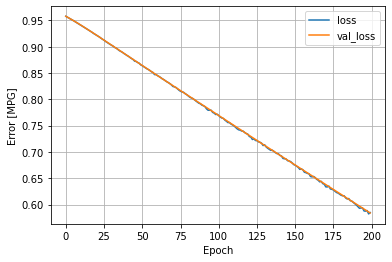

In [73]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [74]:
# Test data
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [75]:
# predict
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

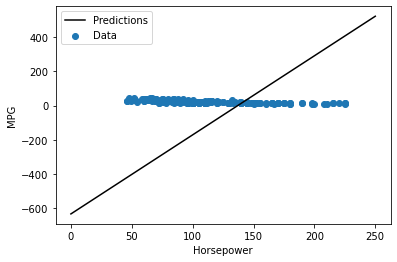

In [76]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()
plot_horsepower(x,y)